In [15]:
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch.nn import Linear
from torch.nn import BatchNorm1d
from torch.utils.data import Dataset
from torch_geometric.nn import GCNConv
from torch_geometric.nn import ChebConv
from torch_geometric.nn import global_add_pool, global_mean_pool
from torch_geometric.data import DataLoader
from torch_scatter import scatter_mean
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

from rdkit import Chem
from rdkit.Chem.rdchem import RWMol
from rdkit.Chem import Draw
from rdkit.Chem import rdmolops
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG = True
from sklearn.metrics import classification_report

import torch.nn as nn
import math
import pickle

In [6]:
df_rdm = pd.read_csv('ChEMBL240_1_30_1295_2052.csv')

In [7]:
df_rdm

,Unnamed: 0,Canonical_smiles,ClassD,No
0,2028,Fc1ccc(cc1)S(=O)(=O)NC(=O)NC2CCN(Cc3ccn(c3)c4c...,0,3
1,7239,COc1ccc(cc1)c2oc(nn2)C(=O)N3CCC(CC3)Oc4ccc(CN5...,0,6
2,6181,CN1C[C@H](c2ccc3sccc3c2)c4ccc(cc4C1)N5CCOCC5,1,9
3,35,Oc1ccc(cc1)c2sc3cc(O)ccc3c2C(=O)c4ccc(OCCN5CCC...,0,14
4,4256,CS(=O)(=O)Cc1cc(nc(n1)c2ccc3[nH]ccc3c2)N4CC5CC...,0,15
...,...,...,...,...
3342,6490,O[C@@]1(CC23CCC(CC2)(CO3)NCc4ncc5OCCOc5c4Cl)CN...,0,8328
3343,1319,O[C@H](COc1cc(O)ccc1C(=O)N2C[C@H](O)CO2)CN3CCC...,1,8331
3344,4810,COc1ccc2N=CC(=O)N(CCN3CCC(CC3)NCc4ccc5OCC(=O)N...,0,8333
3345,5978,CC(C)N(C)[C@@H]1CC[C@@H]([C@H](CS(=O)(=O)C(C)(...,0,8334


In [8]:
def mol2graph(mol):
    res = np.zeros((2, 60)) #for token
    
    for i, bond in enumerate(mol.GetBonds()):
        typ = str(bond.GetBondType())
        begin = bond.GetBeginAtomIdx()
        end = bond.GetEndAtomIdx()
        res[0, i] = begin
        res[1, i] = end
        
    return res

Adj 
 [[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  8. 10. 11. 12. 12. 14. 15. 16. 16.
  18. 19. 20.  6. 22. 23. 20.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.]
 [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
  19. 20. 21. 22. 23.  3. 14.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.]]


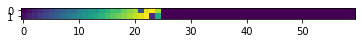

In [9]:
mm = Chem.MolFromSmiles('CCOc1ccc(NC(=S)NNC(=O)c2cc(Br)ccc2Cl)cc1')
rr = mol2graph(mm)
print("Adj", '\n', rr)
plt.imshow(rr)

In [10]:
def one_of_k_encoding(x, allowable_set):
    if x not in allowable_set:
        raise Exception("input {0} not in allowable set{1}:".format(
            x, allowable_set))
    return list(map(lambda s: x == s, allowable_set))
 
def one_of_k_encoding_unk(x, allowable_set):
    """Maps inputs not in the allowable set to the last element."""
    if x not in allowable_set:
        x = allowable_set[-1]
    return list(map(lambda s: x == s, allowable_set))

def atom_features(atom,
                  bool_id_feat=False,
                  explicit_H=False,
                  use_chirality=False):
    if bool_id_feat:
        return np.array([atom_to_id(atom)])
    else:
        from rdkit import Chem
        results = one_of_k_encoding_unk(
          atom.GetSymbol(),
          [
            'C', 
            'N',
            'O',
            'S',
            'F', 
            'P',
            'Cl',
            'Br',
            'Unknown'
              ]) + one_of_k_encoding_unk(atom.GetDegree(),
                             [1, 2, 3, 4, 5, 6, 'Max']) + \
              one_of_k_encoding_unk(atom.GetImplicitValence(), [0, 1, 2, 3, 4, 5, 6]) + \
              [atom.GetFormalCharge(), atom.GetNumRadicalElectrons()] + \
              one_of_k_encoding_unk(atom.GetHybridization(), [
                Chem.rdchem.HybridizationType.SP, Chem.rdchem.HybridizationType.SP2,
                Chem.rdchem.HybridizationType.SP3, Chem.rdchem.HybridizationType.
                                    SP3D, Chem.rdchem.HybridizationType.SP3D2
              ]) + [atom.GetIsAromatic()]
    
    # In case of explicit hydrogen(QM8, QM9), avoid calling `GetTotalNumHs`
    if not explicit_H:
        results = results + one_of_k_encoding_unk(atom.GetTotalNumHs(),
                                                [0, 1, 2, 3, 4])
    if use_chirality:
        
        try:
            results = results + one_of_k_encoding_unk(
                atom.GetProp('_CIPCode'),
                ['R', 'S']) + [atom.HasProp('_ChiralityPossible')]
        except:
            results = results + [False, False
                                ] + [atom.HasProp('_ChiralityPossible')]

    return np.array(results)

In [11]:
ckeckmol = Chem.MolFromSmiles('Cc1ccccc1')

def mol2feat(mol):
    atoms = mol.GetAtoms()
    res = np.zeros((45, 36)) # Set it
    for i,atom in enumerate(atoms):
        node_f = atom_features(atom)
        res[i,:] = node_f
    return res

print(mol2feat(ckeckmol).shape)
print(mol2graph(ckeckmol).shape)

(45, 36)
(2, 60)


In [12]:
arr_A = np.zeros((3347, 2, 60)) # delete 10 mols which over 45 atoms
arr_X = np.zeros((3347, 45, 36))
label = np.zeros((3347,))

for i,word in enumerate(list(df_rdm['Canonical_smiles'])):
    mol = Chem.MolFromSmiles(word) #mol
    adj = mol2graph(mol) #(2,45)
    feat = mol2feat(mol) #(45,36)
    lab = list(df_rdm['ClassD'])[i]
    # save into output
    arr_A[i,:,:] = adj
    arr_X[i,:,:] = feat
    label[i] = lab

##########################
arr_A = np.float32(arr_A) #(12634, 45, 45, 12)
arr_X = np.float32(arr_X) #(12634, 45, 75)
label = np.expand_dims(label, axis=1) #(12634, 1)
print(arr_A.shape)

(3347, 2, 60)


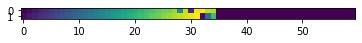

In [13]:
plt.imshow(arr_A[3346,:])

In [16]:
n_features = 36

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(n_features, 128, cached=False) # if you defined cache=True, the shape of batch must be same!
        self.bn1 = BatchNorm1d(128)
        self.conv2 = GCNConv(128, 64, cached=False)
        self.bn2 = BatchNorm1d(64)
        self.fc1 = Linear(64, 64)
        self.bn3 = BatchNorm1d(64)
        self.fc2 = Linear(64, 64)
        self.fc3 = Linear(64, 3)
         
    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = torch.sum(x,0)
        x = x.reshape(1, 64)
        #x = global_add_pool(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        return x

In [21]:
import torch
from torch.utils.data import DataLoader, ConcatDataset
from sklearn.model_selection import KFold
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
k_folds = 10
epochs = 100
ac_list=[[],[],[],[],[],[],[],[],[],[]]
loss_list=[[],[],[],[],[],[],[],[],[],[]]
val_loss_list=[[],[],[],[],[],[],[],[],[],[]]
# Define the K-fold Cross Validator
kfold = KFold(n_splits=k_folds, shuffle=False)
# Start print
print("------Start-----------------")
# K-fold Cross Validation model evaluation
for fold, (train_ids, test_ids) in enumerate(kfold.split(arr_A)):
    print(f'FOLD {fold}')
    
    #---- numpy to tensor --------
    tens_A = torch.from_numpy(arr_A)
    tens_X = torch.from_numpy(arr_X)
    tens_lab = torch.from_numpy(label)
    tens_lab = tens_lab.long()
    traindataset = torch.utils.data.TensorDataset(tens_A[train_ids], tens_X[train_ids], tens_lab[train_ids])
    testdataset = torch.utils.data.TensorDataset(tens_A[test_ids], tens_X[test_ids], tens_lab[test_ids])
    
    # Define data loaders for training and testing data in this fold
    trainloader = torch.utils.data.DataLoader(
                      traindataset, 
                      batch_size=16, shuffle=False)
    testloader = torch.utils.data.DataLoader(
                      testdataset,
                      batch_size=16, shuffle=False)
    
    # 初始化模型 优化器
    model = Net().to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters())
    celoss = nn.CrossEntropyLoss()
    acc_max = 0.01
    loss_min = 9999
    
    # 训练开始
    for i in range(epochs):
        count = 0
        running_loss = 0.0
        for batch_idx, (A, X, y) in enumerate(trainloader):
            A = A[0,:].long().to(DEVICE)
            X = X[0,:].to(DEVICE)
            model.zero_grad()
            y = y[0].to(DEVICE)
            pred = model(X, A)
            loss = celoss(pred, y)
            loss.backward()
            optimizer.step()
            count +=1
            running_loss += loss.item()   
        loss_loss =  running_loss/count
        loss_list[fold].append(loss_loss)
        print("Fold: ", fold, "-- epoch",i+1,"finished")
        print("train_loss:", loss_loss)
        count = 0
        pre = []
        lab = []
        loss_loss = 0.0
        running_loss = 0.0
        for batch_idx, (A, X, y) in enumerate(testloader):
            A = A[0,:].long().to(DEVICE)
            X = X[0,:].to(DEVICE)
            y = y[0].to(DEVICE)
            pred = model(X, A)
            loss = celoss(pred, y)
            running_loss += loss.item()
            count += 1
            ###########
            _, y_pred = torch.max(pred.data, 1)
            y_pred = y_pred.detach().tolist()
            y = y.detach().tolist()
            pre = pre+y_pred
            lab = lab+y
        loss_loss = running_loss/count
        val_loss_list[fold].append(loss_loss)
        print("val_loss:", loss_loss)
        cl = classification_report(lab, pre, output_dict=True)
        print(classification_report(lab, pre))
        ac_list[fold].append(cl['accuracy'])
        if acc_max<cl['accuracy']:
            acc_max=cl['accuracy']
            save_path = f'model/1_30/best_in_fold_{fold}.pth'
            torch.save(model.state_dict(), save_path)
            
        if loss_min>loss_loss:
            loss_min=loss_loss
    #         torch.save(model.state_dict(),'model_dict/A1_hed4_wash')
        print('---------------------------------')


------Start-----------------
FOLD 0
Fold:  0 -- epoch 1 finished
train_loss: 0.7813363156069524
val_loss: 0.6515475107090813
              precision    recall  f1-score   support

           0       0.65      1.00      0.79        13
           1       1.00      0.12      0.22         8

    accuracy                           0.67        21
   macro avg       0.82      0.56      0.51        21
weighted avg       0.78      0.67      0.57        21

---------------------------------
Fold:  0 -- epoch 2 finished
train_loss: 0.6977362182168734
val_loss: 0.595138458268983
              precision    recall  f1-score   support

           0       0.72      1.00      0.84        13
           1       1.00      0.38      0.55         8

    accuracy                           0.76        21
   macro avg       0.86      0.69      0.69        21
weighted avg       0.83      0.76      0.73        21

---------------------------------
Fold:  0 -- epoch 3 finished
train_loss: 0.6575605472914441
val_l

D:\Conda\envs\Py3_8\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Conda\envs\Py3_8\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Conda\envs\Py3_8\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Conda\envs\Py3_8\lib\site-packages\sklearn\metrics\_classification.

Fold:  0 -- epoch 4 finished
train_loss: 0.649406957188769
val_loss: 0.5998644589313439
              precision    recall  f1-score   support

           0       0.68      1.00      0.81        13
           1       1.00      0.25      0.40         8

    accuracy                           0.71        21
   macro avg       0.84      0.62      0.61        21
weighted avg       0.80      0.71      0.66        21

---------------------------------
Fold:  0 -- epoch 5 finished
train_loss: 0.6138388816065219
val_loss: 0.5457898395224696
              precision    recall  f1-score   support

           0       0.82      0.69      0.75        13
           1       0.60      0.75      0.67         8

    accuracy                           0.71        21
   macro avg       0.71      0.72      0.71        21
weighted avg       0.74      0.71      0.72        21

---------------------------------
Fold:  0 -- epoch 6 finished
train_loss: 0.6116703194664623
val_loss: 0.5726811162950027
            

Fold:  0 -- epoch 23 finished
train_loss: 0.28433936513410285
val_loss: 2.5836430633575045
              precision    recall  f1-score   support

           0       0.77      0.77      0.77        13
           1       0.62      0.62      0.62         8

    accuracy                           0.71        21
   macro avg       0.70      0.70      0.70        21
weighted avg       0.71      0.71      0.71        21

---------------------------------
Fold:  0 -- epoch 24 finished
train_loss: 0.24361250025617254
val_loss: 3.7845316081539275
              precision    recall  f1-score   support

           0       0.78      0.54      0.64        13
           1       0.50      0.75      0.60         8

    accuracy                           0.62        21
   macro avg       0.64      0.64      0.62        21
weighted avg       0.67      0.62      0.62        21

---------------------------------
Fold:  0 -- epoch 25 finished
train_loss: 0.2766860248547241
val_loss: 3.8833946294003647
      

Fold:  0 -- epoch 42 finished
train_loss: 0.2241015030545406
val_loss: 7.6898291478734375
              precision    recall  f1-score   support

           0       0.69      0.69      0.69        13
           1       0.50      0.50      0.50         8

    accuracy                           0.62        21
   macro avg       0.60      0.60      0.60        21
weighted avg       0.62      0.62      0.62        21

---------------------------------
Fold:  0 -- epoch 43 finished
train_loss: 0.13612496167381016
val_loss: 8.580082854295972
              precision    recall  f1-score   support

           0       0.80      0.92      0.86        13
           1       0.83      0.62      0.71         8

    accuracy                           0.81        21
   macro avg       0.82      0.77      0.79        21
weighted avg       0.81      0.81      0.80        21

---------------------------------
Fold:  0 -- epoch 44 finished
train_loss: 0.13076870469087945
val_loss: 8.707322814497838
        

Fold:  0 -- epoch 61 finished
train_loss: 0.08145056687360731
val_loss: 9.97083316603377
              precision    recall  f1-score   support

           0       0.79      0.85      0.81        13
           1       0.71      0.62      0.67         8

    accuracy                           0.76        21
   macro avg       0.75      0.74      0.74        21
weighted avg       0.76      0.76      0.76        21

---------------------------------
Fold:  0 -- epoch 62 finished
train_loss: 0.04299657897851382
val_loss: 13.332592034839356
              precision    recall  f1-score   support

           0       0.85      0.85      0.85        13
           1       0.75      0.75      0.75         8

    accuracy                           0.81        21
   macro avg       0.80      0.80      0.80        21
weighted avg       0.81      0.81      0.81        21

---------------------------------
Fold:  0 -- epoch 63 finished
train_loss: 0.02900848324858576
val_loss: 11.35089611033232
        

Fold:  0 -- epoch 80 finished
train_loss: 0.02199781069535905
val_loss: 10.028504166573052
              precision    recall  f1-score   support

           0       0.80      0.92      0.86        13
           1       0.83      0.62      0.71         8

    accuracy                           0.81        21
   macro avg       0.82      0.77      0.79        21
weighted avg       0.81      0.81      0.80        21

---------------------------------
Fold:  0 -- epoch 81 finished
train_loss: 0.01474390453609724
val_loss: 10.425928544347153
              precision    recall  f1-score   support

           0       0.80      0.92      0.86        13
           1       0.83      0.62      0.71         8

    accuracy                           0.81        21
   macro avg       0.82      0.77      0.79        21
weighted avg       0.81      0.81      0.80        21

---------------------------------
Fold:  0 -- epoch 82 finished
train_loss: 0.00562745540055232
val_loss: 10.37913003225717
      

Fold:  0 -- epoch 99 finished
train_loss: 0.30370114315083857
val_loss: 12.564998278455754
              precision    recall  f1-score   support

           0       0.80      0.62      0.70        13
           1       0.55      0.75      0.63         8

    accuracy                           0.67        21
   macro avg       0.67      0.68      0.66        21
weighted avg       0.70      0.67      0.67        21

---------------------------------
Fold:  0 -- epoch 100 finished
train_loss: 0.5065382220125458
val_loss: 4.0810723691349535
              precision    recall  f1-score   support

           0       0.85      0.85      0.85        13
           1       0.75      0.75      0.75         8

    accuracy                           0.81        21
   macro avg       0.80      0.80      0.80        21
weighted avg       0.81      0.81      0.81        21

---------------------------------
FOLD 1
Fold:  1 -- epoch 1 finished
train_loss: 0.8591210622458704
val_loss: 0.6520078409285772


D:\Conda\envs\Py3_8\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Conda\envs\Py3_8\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Conda\envs\Py3_8\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Conda\envs\Py3_8\lib\site-packages\sklearn\metrics\_classification.

Fold:  1 -- epoch 3 finished
train_loss: 0.6628445657512183
val_loss: 0.6594689318111965
              precision    recall  f1-score   support

           0       0.63      0.92      0.75        13
           1       0.50      0.12      0.20         8

    accuracy                           0.62        21
   macro avg       0.57      0.52      0.47        21
weighted avg       0.58      0.62      0.54        21

---------------------------------
Fold:  1 -- epoch 4 finished
train_loss: 0.6248135545768987
val_loss: 0.6313086964544796
              precision    recall  f1-score   support

           0       0.64      0.69      0.67        13
           1       0.43      0.38      0.40         8

    accuracy                           0.57        21
   macro avg       0.54      0.53      0.53        21
weighted avg       0.56      0.57      0.57        21

---------------------------------
Fold:  1 -- epoch 5 finished
train_loss: 0.5622320830616878
val_loss: 0.6167758320059095
           

Fold:  1 -- epoch 22 finished
train_loss: 0.3213660982261849
val_loss: 0.600934398834527
              precision    recall  f1-score   support

           0       0.89      0.62      0.73        13
           1       0.58      0.88      0.70         8

    accuracy                           0.71        21
   macro avg       0.74      0.75      0.71        21
weighted avg       0.77      0.71      0.72        21

---------------------------------
Fold:  1 -- epoch 23 finished
train_loss: 0.3559519213003584
val_loss: 0.3613054730064635
              precision    recall  f1-score   support

           0       0.92      0.92      0.92        13
           1       0.88      0.88      0.88         8

    accuracy                           0.90        21
   macro avg       0.90      0.90      0.90        21
weighted avg       0.90      0.90      0.90        21

---------------------------------
Fold:  1 -- epoch 24 finished
train_loss: 0.26794282648960815
val_loss: 0.4128071179475228
        

Fold:  1 -- epoch 41 finished
train_loss: 0.09696294889617672
val_loss: 0.7741071627386711
              precision    recall  f1-score   support

           0       0.89      0.62      0.73        13
           1       0.58      0.88      0.70         8

    accuracy                           0.71        21
   macro avg       0.74      0.75      0.71        21
weighted avg       0.77      0.71      0.72        21

---------------------------------
Fold:  1 -- epoch 42 finished
train_loss: 0.07401573542153408
val_loss: 1.1714371790364801
              precision    recall  f1-score   support

           0       0.88      0.54      0.67        13
           1       0.54      0.88      0.67         8

    accuracy                           0.67        21
   macro avg       0.71      0.71      0.67        21
weighted avg       0.75      0.67      0.67        21

---------------------------------
Fold:  1 -- epoch 43 finished
train_loss: 0.04913036478902158
val_loss: 1.1217061761352003
     

Fold:  1 -- epoch 60 finished
train_loss: 0.07624408289491943
val_loss: 1.526575266407362
              precision    recall  f1-score   support

           0       0.75      0.46      0.57        13
           1       0.46      0.75      0.57         8

    accuracy                           0.57        21
   macro avg       0.61      0.61      0.57        21
weighted avg       0.64      0.57      0.57        21

---------------------------------
Fold:  1 -- epoch 61 finished
train_loss: 0.09657735186885087
val_loss: 1.6246188969039936
              precision    recall  f1-score   support

           0       0.83      0.38      0.53        13
           1       0.47      0.88      0.61         8

    accuracy                           0.57        21
   macro avg       0.65      0.63      0.57        21
weighted avg       0.69      0.57      0.56        21

---------------------------------
Fold:  1 -- epoch 62 finished
train_loss: 0.15473395761203815
val_loss: 0.9608251372134679
      

Fold:  1 -- epoch 79 finished
train_loss: 0.06996507473191974
val_loss: 1.2659040280992062
              precision    recall  f1-score   support

           0       0.90      0.69      0.78        13
           1       0.64      0.88      0.74         8

    accuracy                           0.76        21
   macro avg       0.77      0.78      0.76        21
weighted avg       0.80      0.76      0.77        21

---------------------------------
Fold:  1 -- epoch 80 finished
train_loss: 0.06788896479416594
val_loss: 1.5645348240278654
              precision    recall  f1-score   support

           0       0.82      0.69      0.75        13
           1       0.60      0.75      0.67         8

    accuracy                           0.71        21
   macro avg       0.71      0.72      0.71        21
weighted avg       0.74      0.71      0.72        21

---------------------------------
Fold:  1 -- epoch 81 finished
train_loss: 0.017548501673506474
val_loss: 1.336571078137749
     

Fold:  1 -- epoch 98 finished
train_loss: 0.0013027398607353238
val_loss: 1.4793111441542481
              precision    recall  f1-score   support

           0       0.83      0.77      0.80        13
           1       0.67      0.75      0.71         8

    accuracy                           0.76        21
   macro avg       0.75      0.76      0.75        21
weighted avg       0.77      0.76      0.76        21

---------------------------------
Fold:  1 -- epoch 99 finished
train_loss: 0.0006666791335316315
val_loss: 1.744838716970483
              precision    recall  f1-score   support

           0       0.83      0.77      0.80        13
           1       0.67      0.75      0.71         8

    accuracy                           0.76        21
   macro avg       0.75      0.76      0.75        21
weighted avg       0.77      0.76      0.76        21

---------------------------------
Fold:  1 -- epoch 100 finished
train_loss: 0.0007426354663093679
val_loss: 1.8560030289608858

D:\Conda\envs\Py3_8\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Conda\envs\Py3_8\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Conda\envs\Py3_8\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Conda\envs\Py3_8\lib\site-packages\sklearn\metrics\_classification.

Fold:  2 -- epoch 2 finished
train_loss: 0.6871381715413124
val_loss: 0.6353815141178313
              precision    recall  f1-score   support

           0       0.65      1.00      0.79        13
           1       1.00      0.12      0.22         8

    accuracy                           0.67        21
   macro avg       0.82      0.56      0.51        21
weighted avg       0.78      0.67      0.57        21

---------------------------------
Fold:  2 -- epoch 3 finished
train_loss: 0.6556957826491386
val_loss: 0.6319248200882048
              precision    recall  f1-score   support

           0       0.61      0.85      0.71        13
           1       0.33      0.12      0.18         8

    accuracy                           0.57        21
   macro avg       0.47      0.49      0.45        21
weighted avg       0.51      0.57      0.51        21

---------------------------------
Fold:  2 -- epoch 4 finished
train_loss: 0.6258067050973377
val_loss: 0.6272003522941044
           

Fold:  2 -- epoch 21 finished
train_loss: 0.3860626309226467
val_loss: 0.5759597889014653
              precision    recall  f1-score   support

           0       0.80      0.62      0.70        13
           1       0.55      0.75      0.63         8

    accuracy                           0.67        21
   macro avg       0.67      0.68      0.66        21
weighted avg       0.70      0.67      0.67        21

---------------------------------
Fold:  2 -- epoch 22 finished
train_loss: 0.30743206286850877
val_loss: 2.0869547899731384
              precision    recall  f1-score   support

           0       0.80      0.31      0.44        13
           1       0.44      0.88      0.58         8

    accuracy                           0.52        21
   macro avg       0.62      0.59      0.51        21
weighted avg       0.66      0.52      0.50        21

---------------------------------
Fold:  2 -- epoch 23 finished
train_loss: 0.2788837223342762
val_loss: 1.7984303064379328
       

Fold:  2 -- epoch 40 finished
train_loss: 0.13524431375147267
val_loss: 4.394656576430338
              precision    recall  f1-score   support

           0       0.80      0.31      0.44        13
           1       0.44      0.88      0.58         8

    accuracy                           0.52        21
   macro avg       0.62      0.59      0.51        21
weighted avg       0.66      0.52      0.50        21

---------------------------------
Fold:  2 -- epoch 41 finished
train_loss: 0.15279766289298274
val_loss: 1.9960212233078372
              precision    recall  f1-score   support

           0       1.00      0.38      0.56        13
           1       0.50      1.00      0.67         8

    accuracy                           0.62        21
   macro avg       0.75      0.69      0.61        21
weighted avg       0.81      0.62      0.60        21

---------------------------------
Fold:  2 -- epoch 42 finished
train_loss: 0.17232032839034964
val_loss: 3.086766611923154
       

Fold:  2 -- epoch 59 finished
train_loss: 0.13038005098692215
val_loss: 1.9175465063526373
              precision    recall  f1-score   support

           0       0.83      0.77      0.80        13
           1       0.67      0.75      0.71         8

    accuracy                           0.76        21
   macro avg       0.75      0.76      0.75        21
weighted avg       0.77      0.76      0.76        21

---------------------------------
Fold:  2 -- epoch 60 finished
train_loss: 0.06330654028205031
val_loss: 2.157979700481519
              precision    recall  f1-score   support

           0       0.83      0.77      0.80        13
           1       0.67      0.75      0.71         8

    accuracy                           0.76        21
   macro avg       0.75      0.76      0.75        21
weighted avg       0.77      0.76      0.76        21

---------------------------------
Fold:  2 -- epoch 61 finished
train_loss: 0.03209910683765703
val_loss: 2.240462195569459
       

Fold:  2 -- epoch 78 finished
train_loss: 0.00021367361486605965
val_loss: 2.717378990420378
              precision    recall  f1-score   support

           0       0.83      0.77      0.80        13
           1       0.67      0.75      0.71         8

    accuracy                           0.76        21
   macro avg       0.75      0.76      0.75        21
weighted avg       0.77      0.76      0.76        21

---------------------------------
Fold:  2 -- epoch 79 finished
train_loss: 0.00013197973519967998
val_loss: 3.0407854375283736
              precision    recall  f1-score   support

           0       0.85      0.85      0.85        13
           1       0.75      0.75      0.75         8

    accuracy                           0.81        21
   macro avg       0.80      0.80      0.80        21
weighted avg       0.81      0.81      0.81        21

---------------------------------
Fold:  2 -- epoch 80 finished
train_loss: 0.00011068577955766929
val_loss: 2.90344441502156

Fold:  2 -- epoch 97 finished
train_loss: 3.1112877308943994e-05
val_loss: 4.05559902647624
              precision    recall  f1-score   support

           0       0.85      0.85      0.85        13
           1       0.75      0.75      0.75         8

    accuracy                           0.81        21
   macro avg       0.80      0.80      0.80        21
weighted avg       0.81      0.81      0.81        21

---------------------------------
Fold:  2 -- epoch 98 finished
train_loss: 1.2865935664266877e-05
val_loss: 3.98784647915158
              precision    recall  f1-score   support

           0       0.85      0.85      0.85        13
           1       0.75      0.75      0.75         8

    accuracy                           0.81        21
   macro avg       0.80      0.80      0.80        21
weighted avg       0.81      0.81      0.81        21

---------------------------------
Fold:  2 -- epoch 99 finished
train_loss: 9.395637687496507e-06
val_loss: 3.6967781471487653
 

D:\Conda\envs\Py3_8\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Conda\envs\Py3_8\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Conda\envs\Py3_8\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Conda\envs\Py3_8\lib\site-packages\sklearn\metrics\_classification.

Fold:  3 -- epoch 3 finished
train_loss: 0.6823877326986462
val_loss: 0.7517031956286657
              precision    recall  f1-score   support

           0       0.43      1.00      0.60         9
           1       0.00      0.00      0.00        12

    accuracy                           0.43        21
   macro avg       0.21      0.50      0.30        21
weighted avg       0.18      0.43      0.26        21

---------------------------------


D:\Conda\envs\Py3_8\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Conda\envs\Py3_8\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Conda\envs\Py3_8\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Conda\envs\Py3_8\lib\site-packages\sklearn\metrics\_classification.

Fold:  3 -- epoch 4 finished
train_loss: 0.6263904291766859
val_loss: 0.6264496005716778
              precision    recall  f1-score   support

           0       0.60      1.00      0.75         9
           1       1.00      0.50      0.67        12

    accuracy                           0.71        21
   macro avg       0.80      0.75      0.71        21
weighted avg       0.83      0.71      0.70        21

---------------------------------
Fold:  3 -- epoch 5 finished
train_loss: 0.6152995431962948
val_loss: 0.6357839888050443
              precision    recall  f1-score   support

           0       0.56      1.00      0.72         9
           1       1.00      0.42      0.59        12

    accuracy                           0.67        21
   macro avg       0.78      0.71      0.65        21
weighted avg       0.81      0.67      0.64        21

---------------------------------
Fold:  3 -- epoch 6 finished
train_loss: 0.6142690244457862
val_loss: 0.6016707917054495
           

Fold:  3 -- epoch 23 finished
train_loss: 0.34258979682612645
val_loss: 0.554086842056249
              precision    recall  f1-score   support

           0       0.67      0.89      0.76         9
           1       0.89      0.67      0.76        12

    accuracy                           0.76        21
   macro avg       0.78      0.78      0.76        21
weighted avg       0.79      0.76      0.76        21

---------------------------------
Fold:  3 -- epoch 24 finished
train_loss: 0.35328311544273394
val_loss: 0.458017664778546
              precision    recall  f1-score   support

           0       0.67      0.89      0.76         9
           1       0.89      0.67      0.76        12

    accuracy                           0.76        21
   macro avg       0.78      0.78      0.76        21
weighted avg       0.79      0.76      0.76        21

---------------------------------
Fold:  3 -- epoch 25 finished
train_loss: 0.3091559310035223
val_loss: 0.5458061047682004
        

Fold:  3 -- epoch 42 finished
train_loss: 0.18353041426959293
val_loss: 0.8595386004742617
              precision    recall  f1-score   support

           0       0.55      0.67      0.60         9
           1       0.70      0.58      0.64        12

    accuracy                           0.62        21
   macro avg       0.62      0.62      0.62        21
weighted avg       0.63      0.62      0.62        21

---------------------------------
Fold:  3 -- epoch 43 finished
train_loss: 0.21570721611956323
val_loss: 1.2746472900622021
              precision    recall  f1-score   support

           0       0.60      0.67      0.63         9
           1       0.73      0.67      0.70        12

    accuracy                           0.67        21
   macro avg       0.66      0.67      0.66        21
weighted avg       0.67      0.67      0.67        21

---------------------------------
Fold:  3 -- epoch 44 finished
train_loss: 0.1843581247029305
val_loss: 1.1688824211676119
      

Fold:  3 -- epoch 61 finished
train_loss: 0.1486332468396886
val_loss: 1.2807792849061579
              precision    recall  f1-score   support

           0       0.67      0.89      0.76         9
           1       0.89      0.67      0.76        12

    accuracy                           0.76        21
   macro avg       0.78      0.78      0.76        21
weighted avg       0.79      0.76      0.76        21

---------------------------------
Fold:  3 -- epoch 62 finished
train_loss: 0.12395689562920965
val_loss: 1.6781219214153897
              precision    recall  f1-score   support

           0       0.70      0.78      0.74         9
           1       0.82      0.75      0.78        12

    accuracy                           0.76        21
   macro avg       0.76      0.76      0.76        21
weighted avg       0.77      0.76      0.76        21

---------------------------------
Fold:  3 -- epoch 63 finished
train_loss: 0.19894882932505856
val_loss: 1.380553541034065
       

Fold:  3 -- epoch 80 finished
train_loss: 0.03383012797020708
val_loss: 1.2640082578493224
              precision    recall  f1-score   support

           0       0.70      0.78      0.74         9
           1       0.82      0.75      0.78        12

    accuracy                           0.76        21
   macro avg       0.76      0.76      0.76        21
weighted avg       0.77      0.76      0.76        21

---------------------------------
Fold:  3 -- epoch 81 finished
train_loss: 0.023999409653781573
val_loss: 1.2380537200998993
              precision    recall  f1-score   support

           0       0.70      0.78      0.74         9
           1       0.82      0.75      0.78        12

    accuracy                           0.76        21
   macro avg       0.76      0.76      0.76        21
weighted avg       0.77      0.76      0.76        21

---------------------------------
Fold:  3 -- epoch 82 finished
train_loss: 0.023127829192060724
val_loss: 1.3156603931308035
   

Fold:  3 -- epoch 99 finished
train_loss: 0.003211363236715632
val_loss: 2.3526939749604674
              precision    recall  f1-score   support

           0       0.78      0.78      0.78         9
           1       0.83      0.83      0.83        12

    accuracy                           0.81        21
   macro avg       0.81      0.81      0.81        21
weighted avg       0.81      0.81      0.81        21

---------------------------------
Fold:  3 -- epoch 100 finished
train_loss: 0.005158032358407368
val_loss: 1.9913376377017133
              precision    recall  f1-score   support

           0       0.78      0.78      0.78         9
           1       0.83      0.83      0.83        12

    accuracy                           0.81        21
   macro avg       0.81      0.81      0.81        21
weighted avg       0.81      0.81      0.81        21

---------------------------------
FOLD 4
Fold:  4 -- epoch 1 finished
train_loss: 0.7740339523270017
val_loss: 0.60681378131821

D:\Conda\envs\Py3_8\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Conda\envs\Py3_8\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Conda\envs\Py3_8\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Conda\envs\Py3_8\lib\site-packages\sklearn\metrics\_classification.

Fold:  4 -- epoch 2 finished
train_loss: 0.7063629314224557
val_loss: 0.6571911289578393
              precision    recall  f1-score   support

           0       0.70      0.93      0.80        15
           1       0.00      0.00      0.00         6

    accuracy                           0.67        21
   macro avg       0.35      0.47      0.40        21
weighted avg       0.50      0.67      0.57        21

---------------------------------
Fold:  4 -- epoch 3 finished
train_loss: 0.6628664208467675
val_loss: 0.6059062395777021
              precision    recall  f1-score   support

           0       0.75      1.00      0.86        15
           1       1.00      0.17      0.29         6

    accuracy                           0.76        21
   macro avg       0.88      0.58      0.57        21
weighted avg       0.82      0.76      0.69        21

---------------------------------
Fold:  4 -- epoch 4 finished
train_loss: 0.6228635078542447
val_loss: 0.5923774994554973
           

Fold:  4 -- epoch 21 finished
train_loss: 0.32702808004202316
val_loss: 1.1379653067865765
              precision    recall  f1-score   support

           0       0.90      0.60      0.72        15
           1       0.45      0.83      0.59         6

    accuracy                           0.67        21
   macro avg       0.68      0.72      0.65        21
weighted avg       0.77      0.67      0.68        21

---------------------------------
Fold:  4 -- epoch 22 finished
train_loss: 0.3140670769298014
val_loss: 0.9977877847947335
              precision    recall  f1-score   support

           0       0.91      0.67      0.77        15
           1       0.50      0.83      0.62         6

    accuracy                           0.71        21
   macro avg       0.70      0.75      0.70        21
weighted avg       0.79      0.71      0.73        21

---------------------------------
Fold:  4 -- epoch 23 finished
train_loss: 0.28219818790844403
val_loss: 1.0532761130348913
      

Fold:  4 -- epoch 40 finished
train_loss: 0.1614521099046833
val_loss: 1.1716261597673185
              precision    recall  f1-score   support

           0       0.92      0.80      0.86        15
           1       0.62      0.83      0.71         6

    accuracy                           0.81        21
   macro avg       0.77      0.82      0.79        21
weighted avg       0.84      0.81      0.82        21

---------------------------------
Fold:  4 -- epoch 41 finished
train_loss: 0.31724920618080393
val_loss: 1.588777561486273
              precision    recall  f1-score   support

           0       0.85      0.73      0.79        15
           1       0.50      0.67      0.57         6

    accuracy                           0.71        21
   macro avg       0.67      0.70      0.68        21
weighted avg       0.75      0.71      0.72        21

---------------------------------
Fold:  4 -- epoch 42 finished
train_loss: 0.21442884129714604
val_loss: 1.0771662377367004
       

Fold:  4 -- epoch 59 finished
train_loss: 0.19882746955427655
val_loss: 1.0947771264174833
              precision    recall  f1-score   support

           0       0.87      0.87      0.87        15
           1       0.67      0.67      0.67         6

    accuracy                           0.81        21
   macro avg       0.77      0.77      0.77        21
weighted avg       0.81      0.81      0.81        21

---------------------------------
Fold:  4 -- epoch 60 finished
train_loss: 0.23137443336828892
val_loss: 0.9872000297920199
              precision    recall  f1-score   support

           0       0.86      0.80      0.83        15
           1       0.57      0.67      0.62         6

    accuracy                           0.76        21
   macro avg       0.71      0.73      0.72        21
weighted avg       0.78      0.76      0.77        21

---------------------------------
Fold:  4 -- epoch 61 finished
train_loss: 0.19089723558181093
val_loss: 0.7319691822285781
     

Fold:  4 -- epoch 78 finished
train_loss: 0.04252836757244111
val_loss: 1.4954307297284686
              precision    recall  f1-score   support

           0       0.86      0.80      0.83        15
           1       0.57      0.67      0.62         6

    accuracy                           0.76        21
   macro avg       0.71      0.73      0.72        21
weighted avg       0.78      0.76      0.77        21

---------------------------------
Fold:  4 -- epoch 79 finished
train_loss: 0.07868966771396052
val_loss: 1.622748020621429
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.50      0.50      0.50         6

    accuracy                           0.71        21
   macro avg       0.65      0.65      0.65        21
weighted avg       0.71      0.71      0.71        21

---------------------------------
Fold:  4 -- epoch 80 finished
train_loss: 0.10930976543663856
val_loss: 1.4934060110476008
      

Fold:  4 -- epoch 97 finished
train_loss: 0.18060211210549437
val_loss: 0.7198223298611784
              precision    recall  f1-score   support

           0       0.81      0.87      0.84        15
           1       0.60      0.50      0.55         6

    accuracy                           0.76        21
   macro avg       0.71      0.68      0.69        21
weighted avg       0.75      0.76      0.75        21

---------------------------------
Fold:  4 -- epoch 98 finished
train_loss: 0.04630713089334799
val_loss: 0.8072165633581919
              precision    recall  f1-score   support

           0       0.81      0.87      0.84        15
           1       0.60      0.50      0.55         6

    accuracy                           0.76        21
   macro avg       0.71      0.68      0.69        21
weighted avg       0.75      0.76      0.75        21

---------------------------------
Fold:  4 -- epoch 99 finished
train_loss: 0.03090934156240091
val_loss: 0.8664380226015012
     

Fold:  5 -- epoch 16 finished
train_loss: 0.4545642416848011
val_loss: 0.5515063057343165
              precision    recall  f1-score   support

           0       0.83      0.45      0.59        11
           1       0.60      0.90      0.72        10

    accuracy                           0.67        21
   macro avg       0.72      0.68      0.65        21
weighted avg       0.72      0.67      0.65        21

---------------------------------
Fold:  5 -- epoch 17 finished
train_loss: 0.42253748256203344
val_loss: 0.5427167833383594
              precision    recall  f1-score   support

           0       0.83      0.45      0.59        11
           1       0.60      0.90      0.72        10

    accuracy                           0.67        21
   macro avg       0.72      0.68      0.65        21
weighted avg       0.72      0.67      0.65        21

---------------------------------
Fold:  5 -- epoch 18 finished
train_loss: 0.4403740057809391
val_loss: 0.4952899513854867
       

Fold:  5 -- epoch 35 finished
train_loss: 0.3093231824269676
val_loss: 0.5094639539075572
              precision    recall  f1-score   support

           0       0.78      0.64      0.70        11
           1       0.67      0.80      0.73        10

    accuracy                           0.71        21
   macro avg       0.72      0.72      0.71        21
weighted avg       0.72      0.71      0.71        21

---------------------------------
Fold:  5 -- epoch 36 finished
train_loss: 0.2741919698821451
val_loss: 0.5155821649823338
              precision    recall  f1-score   support

           0       0.86      0.55      0.67        11
           1       0.64      0.90      0.75        10

    accuracy                           0.71        21
   macro avg       0.75      0.72      0.71        21
weighted avg       0.76      0.71      0.71        21

---------------------------------
Fold:  5 -- epoch 37 finished
train_loss: 0.27560224969662817
val_loss: 0.5389006244949996
       

Fold:  5 -- epoch 54 finished
train_loss: 0.24536273307626288
val_loss: 0.6020403432280762
              precision    recall  f1-score   support

           0       0.78      0.64      0.70        11
           1       0.67      0.80      0.73        10

    accuracy                           0.71        21
   macro avg       0.72      0.72      0.71        21
weighted avg       0.72      0.71      0.71        21

---------------------------------
Fold:  5 -- epoch 55 finished
train_loss: 0.3562712997392866
val_loss: 0.4953431534335583
              precision    recall  f1-score   support

           0       0.78      0.64      0.70        11
           1       0.67      0.80      0.73        10

    accuracy                           0.71        21
   macro avg       0.72      0.72      0.71        21
weighted avg       0.72      0.71      0.71        21

---------------------------------
Fold:  5 -- epoch 56 finished
train_loss: 0.20283616520430567
val_loss: 0.45858537525955834
     

Fold:  5 -- epoch 73 finished
train_loss: 0.075846479217709
val_loss: 0.8304256764619515
              precision    recall  f1-score   support

           0       0.75      0.55      0.63        11
           1       0.62      0.80      0.70        10

    accuracy                           0.67        21
   macro avg       0.68      0.67      0.66        21
weighted avg       0.69      0.67      0.66        21

---------------------------------
Fold:  5 -- epoch 74 finished
train_loss: 0.2032115642881617
val_loss: 0.6133841919830784
              precision    recall  f1-score   support

           0       0.86      0.55      0.67        11
           1       0.64      0.90      0.75        10

    accuracy                           0.71        21
   macro avg       0.75      0.72      0.71        21
weighted avg       0.76      0.71      0.71        21

---------------------------------
Fold:  5 -- epoch 75 finished
train_loss: 0.08961997084487014
val_loss: 0.7370703724337854
        

Fold:  5 -- epoch 92 finished
train_loss: 0.1309027103976963
val_loss: 0.981393092468656
              precision    recall  f1-score   support

           0       0.82      0.82      0.82        11
           1       0.80      0.80      0.80        10

    accuracy                           0.81        21
   macro avg       0.81      0.81      0.81        21
weighted avg       0.81      0.81      0.81        21

---------------------------------
Fold:  5 -- epoch 93 finished
train_loss: 0.03561145395479615
val_loss: 1.022210484300374
              precision    recall  f1-score   support

           0       0.82      0.82      0.82        11
           1       0.80      0.80      0.80        10

    accuracy                           0.81        21
   macro avg       0.81      0.81      0.81        21
weighted avg       0.81      0.81      0.81        21

---------------------------------
Fold:  5 -- epoch 94 finished
train_loss: 0.05120890468793903
val_loss: 1.1623840541090653
        

D:\Conda\envs\Py3_8\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Conda\envs\Py3_8\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Conda\envs\Py3_8\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Conda\envs\Py3_8\lib\site-packages\sklearn\metrics\_classification.

Fold:  6 -- epoch 2 finished
train_loss: 0.6626460602181772
val_loss: 0.5724737424226034
              precision    recall  f1-score   support

           0       0.71      0.92      0.80        13
           1       0.75      0.38      0.50         8

    accuracy                           0.71        21
   macro avg       0.73      0.65      0.65        21
weighted avg       0.72      0.71      0.69        21

---------------------------------
Fold:  6 -- epoch 3 finished
train_loss: 0.6101898408257593
val_loss: 0.5375296867319516
              precision    recall  f1-score   support

           0       0.90      0.69      0.78        13
           1       0.64      0.88      0.74         8

    accuracy                           0.76        21
   macro avg       0.77      0.78      0.76        21
weighted avg       0.80      0.76      0.77        21

---------------------------------
Fold:  6 -- epoch 4 finished
train_loss: 0.5468505955701264
val_loss: 0.4551084965655935
           

Fold:  6 -- epoch 21 finished
train_loss: 0.36721185248655364
val_loss: 0.6545829850559434
              precision    recall  f1-score   support

           0       1.00      0.77      0.87        13
           1       0.73      1.00      0.84         8

    accuracy                           0.86        21
   macro avg       0.86      0.88      0.86        21
weighted avg       0.90      0.86      0.86        21

---------------------------------
Fold:  6 -- epoch 22 finished
train_loss: 0.31756479818386846
val_loss: 0.5001151926401126
              precision    recall  f1-score   support

           0       1.00      0.85      0.92        13
           1       0.80      1.00      0.89         8

    accuracy                           0.90        21
   macro avg       0.90      0.92      0.90        21
weighted avg       0.92      0.90      0.91        21

---------------------------------
Fold:  6 -- epoch 23 finished
train_loss: 0.322993673113979
val_loss: 0.3731818849905505
       

Fold:  6 -- epoch 40 finished
train_loss: 0.2686277013149274
val_loss: 0.8660178614520639
              precision    recall  f1-score   support

           0       1.00      0.69      0.82        13
           1       0.67      1.00      0.80         8

    accuracy                           0.81        21
   macro avg       0.83      0.85      0.81        21
weighted avg       0.87      0.81      0.81        21

---------------------------------
Fold:  6 -- epoch 41 finished
train_loss: 0.33820100957514265
val_loss: 0.5604803670080563
              precision    recall  f1-score   support

           0       0.89      0.62      0.73        13
           1       0.58      0.88      0.70         8

    accuracy                           0.71        21
   macro avg       0.74      0.75      0.71        21
weighted avg       0.77      0.71      0.72        21

---------------------------------
Fold:  6 -- epoch 42 finished
train_loss: 0.1823428621385348
val_loss: 0.9384385851523929
       

Fold:  6 -- epoch 59 finished
train_loss: 0.12032463375084516
val_loss: 1.1124413595375158
              precision    recall  f1-score   support

           0       1.00      0.62      0.76        13
           1       0.62      1.00      0.76         8

    accuracy                           0.76        21
   macro avg       0.81      0.81      0.76        21
weighted avg       0.85      0.76      0.76        21

---------------------------------
Fold:  6 -- epoch 60 finished
train_loss: 0.14513182735972144
val_loss: 0.4020534305897737
              precision    recall  f1-score   support

           0       1.00      0.85      0.92        13
           1       0.80      1.00      0.89         8

    accuracy                           0.90        21
   macro avg       0.90      0.92      0.90        21
weighted avg       0.92      0.90      0.91        21

---------------------------------
Fold:  6 -- epoch 61 finished
train_loss: 0.07890780353752683
val_loss: 0.3886758232053247
     

Fold:  6 -- epoch 78 finished
train_loss: 0.05695778716991264
val_loss: 0.5946720596278153
              precision    recall  f1-score   support

           0       0.85      0.85      0.85        13
           1       0.75      0.75      0.75         8

    accuracy                           0.81        21
   macro avg       0.80      0.80      0.80        21
weighted avg       0.81      0.81      0.81        21

---------------------------------
Fold:  6 -- epoch 79 finished
train_loss: 0.05071704200378562
val_loss: 0.7600425735957591
              precision    recall  f1-score   support

           0       0.83      0.77      0.80        13
           1       0.67      0.75      0.71         8

    accuracy                           0.76        21
   macro avg       0.75      0.76      0.75        21
weighted avg       0.77      0.76      0.76        21

---------------------------------
Fold:  6 -- epoch 80 finished
train_loss: 0.05911577085373251
val_loss: 0.6893740541585419
     

Fold:  6 -- epoch 97 finished
train_loss: 0.05920040489185186
val_loss: 0.7216376083471052
              precision    recall  f1-score   support

           0       0.91      0.77      0.83        13
           1       0.70      0.88      0.78         8

    accuracy                           0.81        21
   macro avg       0.80      0.82      0.81        21
weighted avg       0.83      0.81      0.81        21

---------------------------------
Fold:  6 -- epoch 98 finished
train_loss: 0.04797354090641779
val_loss: 0.7981695081268912
              precision    recall  f1-score   support

           0       0.85      0.85      0.85        13
           1       0.75      0.75      0.75         8

    accuracy                           0.81        21
   macro avg       0.80      0.80      0.80        21
weighted avg       0.81      0.81      0.81        21

---------------------------------
Fold:  6 -- epoch 99 finished
train_loss: 0.03628069411876262
val_loss: 0.7476047643828808
     

D:\Conda\envs\Py3_8\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Conda\envs\Py3_8\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Conda\envs\Py3_8\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Conda\envs\Py3_8\lib\site-packages\sklearn\metrics\_classification.

Fold:  7 -- epoch 2 finished
train_loss: 0.6705621150987489
val_loss: 0.5989043996447608
              precision    recall  f1-score   support

           0       0.68      0.93      0.79        14
           1       0.50      0.14      0.22         7

    accuracy                           0.67        21
   macro avg       0.59      0.54      0.51        21
weighted avg       0.62      0.67      0.60        21

---------------------------------
Fold:  7 -- epoch 3 finished
train_loss: 0.6039969660779068
val_loss: 0.5712558439090138
              precision    recall  f1-score   support

           0       0.68      0.93      0.79        14
           1       0.50      0.14      0.22         7

    accuracy                           0.67        21
   macro avg       0.59      0.54      0.51        21
weighted avg       0.62      0.67      0.60        21

---------------------------------
Fold:  7 -- epoch 4 finished
train_loss: 0.5687180730777857
val_loss: 0.5245870831644251
           

Fold:  7 -- epoch 21 finished
train_loss: 0.3136942276368252
val_loss: 0.9439994164058153
              precision    recall  f1-score   support

           0       0.80      0.86      0.83        14
           1       0.67      0.57      0.62         7

    accuracy                           0.76        21
   macro avg       0.73      0.71      0.72        21
weighted avg       0.76      0.76      0.76        21

---------------------------------
Fold:  7 -- epoch 22 finished
train_loss: 0.31661170085558993
val_loss: 0.9560590807024136
              precision    recall  f1-score   support

           0       0.90      0.64      0.75        14
           1       0.55      0.86      0.67         7

    accuracy                           0.71        21
   macro avg       0.72      0.75      0.71        21
weighted avg       0.78      0.71      0.72        21

---------------------------------
Fold:  7 -- epoch 23 finished
train_loss: 0.29795854862191345
val_loss: 1.2286912495727025
      

Fold:  7 -- epoch 40 finished
train_loss: 0.19635056860093553
val_loss: 3.026689528513088
              precision    recall  f1-score   support

           0       0.76      0.93      0.84        14
           1       0.75      0.43      0.55         7

    accuracy                           0.76        21
   macro avg       0.76      0.68      0.69        21
weighted avg       0.76      0.76      0.74        21

---------------------------------
Fold:  7 -- epoch 41 finished
train_loss: 0.16892795540026917
val_loss: 2.2246980121493647
              precision    recall  f1-score   support

           0       0.82      1.00      0.90        14
           1       1.00      0.57      0.73         7

    accuracy                           0.86        21
   macro avg       0.91      0.79      0.82        21
weighted avg       0.88      0.86      0.84        21

---------------------------------
Fold:  7 -- epoch 42 finished
train_loss: 0.16612075779708213
val_loss: 2.215251671087225
       

Fold:  7 -- epoch 59 finished
train_loss: 0.2000682424743376
val_loss: 1.638274226728451
              precision    recall  f1-score   support

           0       0.77      0.71      0.74        14
           1       0.50      0.57      0.53         7

    accuracy                           0.67        21
   macro avg       0.63      0.64      0.64        21
weighted avg       0.68      0.67      0.67        21

---------------------------------
Fold:  7 -- epoch 60 finished
train_loss: 0.11367206840547268
val_loss: 2.778556119616989
              precision    recall  f1-score   support

           0       0.82      1.00      0.90        14
           1       1.00      0.57      0.73         7

    accuracy                           0.86        21
   macro avg       0.91      0.79      0.82        21
weighted avg       0.88      0.86      0.84        21

---------------------------------
Fold:  7 -- epoch 61 finished
train_loss: 0.07186343280755843
val_loss: 3.145213855050399
         

Fold:  7 -- epoch 78 finished
train_loss: 0.05734863584295895
val_loss: 3.829991445312598
              precision    recall  f1-score   support

           0       0.78      1.00      0.88        14
           1       1.00      0.43      0.60         7

    accuracy                           0.81        21
   macro avg       0.89      0.71      0.74        21
weighted avg       0.85      0.81      0.78        21

---------------------------------
Fold:  7 -- epoch 79 finished
train_loss: 0.2334919873394829
val_loss: 2.2644527143121365
              precision    recall  f1-score   support

           0       0.81      0.93      0.87        14
           1       0.80      0.57      0.67         7

    accuracy                           0.81        21
   macro avg       0.81      0.75      0.77        21
weighted avg       0.81      0.81      0.80        21

---------------------------------
Fold:  7 -- epoch 80 finished
train_loss: 0.04260211681391408
val_loss: 3.66116934712426
         

Fold:  7 -- epoch 97 finished
train_loss: 0.01728160494571946
val_loss: 4.192785771790996
              precision    recall  f1-score   support

           0       0.81      0.93      0.87        14
           1       0.80      0.57      0.67         7

    accuracy                           0.81        21
   macro avg       0.81      0.75      0.77        21
weighted avg       0.81      0.81      0.80        21

---------------------------------
Fold:  7 -- epoch 98 finished
train_loss: 0.04846585102555412
val_loss: 3.9530870801328484
              precision    recall  f1-score   support

           0       0.75      0.86      0.80        14
           1       0.60      0.43      0.50         7

    accuracy                           0.71        21
   macro avg       0.68      0.64      0.65        21
weighted avg       0.70      0.71      0.70        21

---------------------------------
Fold:  7 -- epoch 99 finished
train_loss: 0.016335867650560342
val_loss: 4.283132406661198
      

D:\Conda\envs\Py3_8\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Conda\envs\Py3_8\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Conda\envs\Py3_8\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Conda\envs\Py3_8\lib\site-packages\sklearn\metrics\_classification.

Fold:  8 -- epoch 2 finished
train_loss: 0.6593724355771744
val_loss: 0.7328437878972008
              precision    recall  f1-score   support

           0       0.50      0.91      0.65        11
           1       0.00      0.00      0.00        10

    accuracy                           0.48        21
   macro avg       0.25      0.45      0.32        21
weighted avg       0.26      0.48      0.34        21

---------------------------------
Fold:  8 -- epoch 3 finished
train_loss: 0.6257966524433523
val_loss: 0.6731664112636021
              precision    recall  f1-score   support

           0       0.58      1.00      0.73        11
           1       1.00      0.20      0.33        10

    accuracy                           0.62        21
   macro avg       0.79      0.60      0.53        21
weighted avg       0.78      0.62      0.54        21

---------------------------------
Fold:  8 -- epoch 4 finished
train_loss: 0.5542312381271033
val_loss: 0.717672389178049
            

Fold:  8 -- epoch 21 finished
train_loss: 0.3092506567394171
val_loss: 1.6664147955292545
              precision    recall  f1-score   support

           0       0.70      0.64      0.67        11
           1       0.64      0.70      0.67        10

    accuracy                           0.67        21
   macro avg       0.67      0.67      0.67        21
weighted avg       0.67      0.67      0.67        21

---------------------------------
Fold:  8 -- epoch 22 finished
train_loss: 0.3100384784299754
val_loss: 1.9814849375253891
              precision    recall  f1-score   support

           0       0.56      0.82      0.67        11
           1       0.60      0.30      0.40        10

    accuracy                           0.57        21
   macro avg       0.58      0.56      0.53        21
weighted avg       0.58      0.57      0.54        21

---------------------------------
Fold:  8 -- epoch 23 finished
train_loss: 0.290490895937519
val_loss: 2.1079197408897534
         

Fold:  8 -- epoch 40 finished
train_loss: 0.1811968861924096
val_loss: 6.429370434744106
              precision    recall  f1-score   support

           0       0.62      0.73      0.67        11
           1       0.62      0.50      0.56        10

    accuracy                           0.62        21
   macro avg       0.62      0.61      0.61        21
weighted avg       0.62      0.62      0.61        21

---------------------------------
Fold:  8 -- epoch 41 finished
train_loss: 0.15660358471392732
val_loss: 7.4299271825238105
              precision    recall  f1-score   support

           0       0.57      0.73      0.64        11
           1       0.57      0.40      0.47        10

    accuracy                           0.57        21
   macro avg       0.57      0.56      0.56        21
weighted avg       0.57      0.57      0.56        21

---------------------------------
Fold:  8 -- epoch 42 finished
train_loss: 0.34213513347306634
val_loss: 5.583296988647254
        

Fold:  8 -- epoch 59 finished
train_loss: 0.1948221140283567
val_loss: 8.266157428204073
              precision    recall  f1-score   support

           0       0.62      0.73      0.67        11
           1       0.62      0.50      0.56        10

    accuracy                           0.62        21
   macro avg       0.62      0.61      0.61        21
weighted avg       0.62      0.62      0.61        21

---------------------------------
Fold:  8 -- epoch 60 finished
train_loss: 0.2852077659369133
val_loss: 3.651461546470741
              precision    recall  f1-score   support

           0       0.57      0.73      0.64        11
           1       0.57      0.40      0.47        10

    accuracy                           0.57        21
   macro avg       0.57      0.56      0.56        21
weighted avg       0.57      0.57      0.56        21

---------------------------------
Fold:  8 -- epoch 61 finished
train_loss: 0.1030727664284778
val_loss: 5.0802185522646015
          

Fold:  8 -- epoch 78 finished
train_loss: 0.035138669944239774
val_loss: 7.089454396367896
              precision    recall  f1-score   support

           0       0.64      0.82      0.72        11
           1       0.71      0.50      0.59        10

    accuracy                           0.67        21
   macro avg       0.68      0.66      0.65        21
weighted avg       0.68      0.67      0.66        21

---------------------------------
Fold:  8 -- epoch 79 finished
train_loss: 0.13272901426633962
val_loss: 5.971169841826415
              precision    recall  f1-score   support

           0       0.67      0.73      0.70        11
           1       0.67      0.60      0.63        10

    accuracy                           0.67        21
   macro avg       0.67      0.66      0.66        21
weighted avg       0.67      0.67      0.67        21

---------------------------------
Fold:  8 -- epoch 80 finished
train_loss: 0.04113663954620472
val_loss: 6.555725152358979
       

Fold:  8 -- epoch 97 finished
train_loss: 0.12159982797536613
val_loss: 3.7269074063098846
              precision    recall  f1-score   support

           0       0.69      0.82      0.75        11
           1       0.75      0.60      0.67        10

    accuracy                           0.71        21
   macro avg       0.72      0.71      0.71        21
weighted avg       0.72      0.71      0.71        21

---------------------------------
Fold:  8 -- epoch 98 finished
train_loss: 0.0833920054407707
val_loss: 4.820451619288135
              precision    recall  f1-score   support

           0       0.64      0.82      0.72        11
           1       0.71      0.50      0.59        10

    accuracy                           0.67        21
   macro avg       0.68      0.66      0.65        21
weighted avg       0.68      0.67      0.66        21

---------------------------------
Fold:  8 -- epoch 99 finished
train_loss: 0.046746713448983304
val_loss: 4.109418696410774
       

Fold:  9 -- epoch 16 finished
train_loss: 0.36230815881281786
val_loss: 0.7011050154632401
              precision    recall  f1-score   support

           0       0.73      0.67      0.70        12
           1       0.60      0.67      0.63         9

    accuracy                           0.67        21
   macro avg       0.66      0.67      0.66        21
weighted avg       0.67      0.67      0.67        21

---------------------------------
Fold:  9 -- epoch 17 finished
train_loss: 0.3525622625361429
val_loss: 0.7263749408580008
              precision    recall  f1-score   support

           0       0.80      0.67      0.73        12
           1       0.64      0.78      0.70         9

    accuracy                           0.71        21
   macro avg       0.72      0.72      0.71        21
weighted avg       0.73      0.71      0.72        21

---------------------------------
Fold:  9 -- epoch 18 finished
train_loss: 0.3170722448672632
val_loss: 0.7625185658689588
       

Fold:  9 -- epoch 35 finished
train_loss: 0.18766954264966432
val_loss: 1.2796431738867857
              precision    recall  f1-score   support

           0       0.75      0.75      0.75        12
           1       0.67      0.67      0.67         9

    accuracy                           0.71        21
   macro avg       0.71      0.71      0.71        21
weighted avg       0.71      0.71      0.71        21

---------------------------------
Fold:  9 -- epoch 36 finished
train_loss: 0.20426877215530662
val_loss: 1.4745093498641333
              precision    recall  f1-score   support

           0       0.73      0.67      0.70        12
           1       0.60      0.67      0.63         9

    accuracy                           0.67        21
   macro avg       0.66      0.67      0.66        21
weighted avg       0.67      0.67      0.67        21

---------------------------------
Fold:  9 -- epoch 37 finished
train_loss: 0.21147980303332634
val_loss: 1.1169909921006929
     

Fold:  9 -- epoch 54 finished
train_loss: 0.10143259399253107
val_loss: 1.8033980477282918
              precision    recall  f1-score   support

           0       0.75      0.75      0.75        12
           1       0.67      0.67      0.67         9

    accuracy                           0.71        21
   macro avg       0.71      0.71      0.71        21
weighted avg       0.71      0.71      0.71        21

---------------------------------
Fold:  9 -- epoch 55 finished
train_loss: 0.09149575660655536
val_loss: 1.4680440165591147
              precision    recall  f1-score   support

           0       0.75      0.75      0.75        12
           1       0.67      0.67      0.67         9

    accuracy                           0.71        21
   macro avg       0.71      0.71      0.71        21
weighted avg       0.71      0.71      0.71        21

---------------------------------
Fold:  9 -- epoch 56 finished
train_loss: 0.11569426466196386
val_loss: 1.7395313573121753
     

Fold:  9 -- epoch 73 finished
train_loss: 0.09378728889014475
val_loss: 1.4707992392264018
              precision    recall  f1-score   support

           0       0.75      0.75      0.75        12
           1       0.67      0.67      0.67         9

    accuracy                           0.71        21
   macro avg       0.71      0.71      0.71        21
weighted avg       0.71      0.71      0.71        21

---------------------------------
Fold:  9 -- epoch 74 finished
train_loss: 0.030123947088007058
val_loss: 2.211847210029578
              precision    recall  f1-score   support

           0       0.75      0.75      0.75        12
           1       0.67      0.67      0.67         9

    accuracy                           0.71        21
   macro avg       0.71      0.71      0.71        21
weighted avg       0.71      0.71      0.71        21

---------------------------------
Fold:  9 -- epoch 75 finished
train_loss: 0.032445884557336525
val_loss: 2.6509310482001096
    

Fold:  9 -- epoch 92 finished
train_loss: 0.08653846871134062
val_loss: 1.6849712772802232
              precision    recall  f1-score   support

           0       0.75      0.75      0.75        12
           1       0.67      0.67      0.67         9

    accuracy                           0.71        21
   macro avg       0.71      0.71      0.71        21
weighted avg       0.71      0.71      0.71        21

---------------------------------
Fold:  9 -- epoch 93 finished
train_loss: 0.059213701600354336
val_loss: 1.959181681612138
              precision    recall  f1-score   support

           0       0.75      0.75      0.75        12
           1       0.67      0.67      0.67         9

    accuracy                           0.71        21
   macro avg       0.71      0.71      0.71        21
weighted avg       0.71      0.71      0.71        21

---------------------------------
Fold:  9 -- epoch 94 finished
train_loss: 0.016462098642331734
val_loss: 2.212700831781452
     

In [ ]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
for i in range(0,10):
    
    loss_l = pd.DataFrame(loss_list[i][1:], columns=None)
    val_loss_l = pd.DataFrame(val_loss_list[i][1:], columns=None)
    ac_l = pd.DataFrame(ac_list[i], columns=None)
    
    loss_l.to_csv(f'/home/is/huijia-w/hERG/Data_from_Structure_base_ChEMBL240_for_J/Results/ShetGTN/No_Balanced/Two_Threshold/1_70/Loss_fold_{i}.csv', index=False)
    val_loss_l.to_csv(f'/home/is/huijia-w/hERG/Data_from_Structure_base_ChEMBL240_for_J/Results/ShetGTN/No_Balanced/Two_Threshold/1_70/Vlos_fold_{i}.csv', index=False)
    ac_l.to_csv(f'/home/is/huijia-w/hERG/Data_from_Structure_base_ChEMBL240_for_J/Results/ShetGTN/No_Balanced/Two_Threshold/1_70/Acc_fold_{i}.csv', index=False)

In [24]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)
modeltest = Net().to(DEVICE)
Pre = [[],[],[],[],[],[],[],[],[],[]]
Lab = [[],[],[],[],[],[],[],[],[],[]]
# Define the K-fold Cross Validator
kfold = KFold(n_splits=10, shuffle=False)
for fold, (train_ids, test_ids) in enumerate(kfold.split(arr_A)):
    print(f'FOLD {fold}')
    
    testdataset = torch.utils.data.TensorDataset(tens_A[test_ids], tens_X[test_ids], tens_lab[test_ids])
    
    modeltest.load_state_dict(torch.load(f'model/1_30/best_in_fold_{fold}.pth'))
    testloader2 = DataLoader(testdataset, batch_size=1, shuffle=False, drop_last=False)
   
    for batch_idx, (A, X, y) in enumerate(testloader2):
        A = A[0,:].long().to(DEVICE)
        X = X[0,:].to(DEVICE)
        y = y[0].to(DEVICE)
        pred = modeltest(X, A)
        _, y_pred = torch.max(pred.data, 1)
        y_pred = y_pred.detach().tolist()
        y = y.detach().tolist()
        Pre[fold].append(y_pred)
        Lab[fold].append(y)
    print("fold: ", fold, "\n", classification_report(Lab[fold], Pre[fold], output_dict=True))
    cm1 = confusion_matrix(Lab[fold], Pre[fold])
    tn, fp, fn, tp = confusion_matrix(Lab[fold], Pre[fold]).ravel()
    print("\n", "fold", fold)
    print(cm1)
    print("tn, fp, fn, tp: ", tn, fp, fn, tp)
    fpr, tpr, thresholds = metrics.roc_curve(Lab[fold], Pre[fold], pos_label=1)
    print("AUC: ", metrics.auc(fpr, tpr))
    GHa = (tp*((tp+fp)+(tp+fn))) / (2*(tp+fp)*(tp+fn))
    GHi = (tn*((tn+fn)+(tn+fp))) / (2*(tn+fn)*(tn+fp))
    print("GHa, GHi: ",GHa, GHi)
    NPV = tn/(tn+fn)
    print("NPV",NPV)
    print("===================")

cuda
FOLD 0
fold:  0 
 {'0': {'precision': 0.8435754189944135, 'recall': 0.7587939698492462, 'f1-score': 0.798941798941799, 'support': 199}, '1': {'precision': 0.6923076923076923, 'recall': 0.7941176470588235, 'f1-score': 0.7397260273972601, 'support': 136}, 'accuracy': 0.7731343283582089, 'macro avg': {'precision': 0.7679415556510529, 'recall': 0.7764558084540348, 'f1-score': 0.7693339131695296, 'support': 335}, 'weighted avg': {'precision': 0.7821652374141326, 'recall': 0.7731343283582089, 'f1-score': 0.7749019633296877, 'support': 335}}

 fold 0
[[151  48]
 [ 28 108]]
tn, fp, fn, tp:  151 48 28 108
AUC:  0.7764558084540348
GHa, GHi:  0.7432126696832579 0.8011846944218298
NPV 0.8435754189944135
FOLD 1
fold:  1 
 {'0': {'precision': 0.8608247422680413, 'recall': 0.7695852534562212, 'f1-score': 0.8126520681265207, 'support': 217}, '1': {'precision': 0.6453900709219859, 'recall': 0.7711864406779662, 'f1-score': 0.7027027027027027, 'support': 118}, 'accuracy': 0.7701492537313432, 'macro 

In [87]:
# res_lis = []
# for i in range(len(lab)):
#     if pre[i] == lab[i]:
#         res_lis.append('pass')
#     if pre[i] != lab[i]:
#         res_lis.append('fail')
# df_rdm["result_5"] = res_lis

In [88]:
# df_rdm

,Unnamed: 0,Canonical_smiles,Class,result,Mucko,result_5
0,4538,Cc1cc(on1)[C@H]2C[C@H]3CSC(=N[C@]3(CO2)c4ccc(F...,1,pass,C1=NC2(c3ccccc3)COC(c3ccno3)CC2CS1,pass
1,4658,CCn1cc(cn1)[C@]2(N[C@H](Cc3c2[nH]c4ccccc34)c5n...,1,pass,c1ccc(-c2c[nH]c(C3Cc4c([nH]c5ccccc45)C(c4cn[nH...,pass
2,2208,CC(C)S(=O)(=O)N[C@H]1CN(C)C[C@@H]1c2ccc(cc2)c3...,1,fail,c1cncc(-c2ccc(C3CCNC3)cc2)c1,fail
3,1155,CNCc1ccc(Cl)cc1Oc2ccc(Cl)cc2,1,pass,c1ccc(Oc2ccccc2)cc1,pass
4,4023,CN(C)CCN(C)c1ccc(Nc2cc(NC3CC3)n4ncc(C#N)c4n2)c...,1,pass,c1ccc(Nc2cc(NC3CC3)n3nccc3n2)cc1,pass
...,...,...,...,...,...,...
5783,5295,Fc1ccc(CN2CC3CN(CCNS(=O)(=O)c4ccc(F)cc4)CC(C2)...,0,fail,O=S(=O)(NCCN1CC2CN(Cc3ccccc3)CC(C1)O2)c1ccccc1,pass
5784,51,CC(C)CN(C[C@@H](O)[C@H](Cc1ccccc1)NC(=O)O[C@H]...,0,pass,O=C(NC(CCNS(=O)(=O)c1ccccc1)Cc1ccccc1)OC1CCOC1,pass
5785,634,CN1CCN(Cc2ccc3c(Cc4c(n[nH]c34)c5csc(c5)C#CCOc6...,1,pass,C(#Cc1cc(-c2n[nH]c3c2Cc2cc(CN4CCNCC4)ccc2-3)cs...,pass
5786,831,CCN1C=C(C(=O)O)C(=O)c2cc(F)c(cc12)N3CCN(C)CC3,0,pass,O=c1cc[nH]c2cc(N3CCNCC3)ccc12,pass


In [89]:
# df_rdm.to_csv('rdm66_6res_mko.csv')

In [12]:
# x = torch.randn(4, 16)
# x = torch.tensor(x, requires_grad=True)

# edge_index = torch.tensor([[0.0, 1.0, 2.0, 3.0, 3.0, 3.0],
#                            [3.0, 3.0, 3.0, 0.0, 1.0, 2.0]], dtype=torch.long)


# model = Net()
# output = model(x, edge_index)
# print(output)

torch.Size([4, 64])
torch.Size([64])
tensor([[-1.0890, -1.1120, -1.0950]], grad_fn=<LogSoftmaxBackward0>)


C:\Users\12192\AppData\Local\Temp\ipykernel_1892\1092338973.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, requires_grad=True)
C:\Users\12192\AppData\Local\Temp\ipykernel_1892\1092338973.py:4: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  edge_index = torch.tensor([[0.0, 1.0, 2.0, 3.0, 3.0, 3.0],
